### Convert Mel-Spec

In [2]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image

# Input and output directories
input_dir = "../test/mel_specs/images/sch_ddpm_nisteps_1000"
output_dir = "../test/mel_specs/npy_images"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop through PNG files in the input directory
for filename in tqdm(os.listdir(input_dir)):
    if filename.endswith(".png"):  # Process only PNG files
        # Load image as grayscale
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path).convert("L")
        
        # Convert image to a NumPy array and normalize to range [0, 1]
        img_array = np.array(img, dtype=np.float32) / 255.0
        
        # Save the array as a .npy file
        npy_filename = os.path.splitext(filename)[0] + ".npy"
        np.save(os.path.join(output_dir, npy_filename), img_array)

print("Conversion complete! All .npy files saved.")


100%|██████████| 656/656 [00:31<00:00, 20.94it/s]

Conversion complete! All .npy files saved.


### Split SSD dataset into train/val/test

In [1]:
import os
import random
import shutil

source_dir = "../cache/spotify_sleep_dataset"
train_dir = os.path.join(source_dir, "train")
val_dir = os.path.join(source_dir, "val")
test_dir = os.path.join(source_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

wav_files = [f for f in os.listdir(source_dir) if f.endswith(".wav")]

random.shuffle(wav_files)

total_files = len(wav_files)
train_split = int(total_files * 0.9)
val_split = int(total_files * 0.95)

train_files = wav_files[:train_split]
val_files = wav_files[train_split:val_split]
test_files = wav_files[val_split:]

for f in train_files:
    shutil.move(os.path.join(source_dir, f), train_dir)

for f in val_files:
    shutil.move(os.path.join(source_dir, f), val_dir)

for f in test_files:
    shutil.move(os.path.join(source_dir, f), test_dir)

len_train = len(os.listdir(train_dir))
len_val = len(os.listdir(val_dir))
len_test = len(os.listdir(test_dir))

len_train, len_val, len_test

(10333, 574, 575)

### Testing Pre-trained Models

#### TODO
- test and see if just scaling the mel-spectrogram is able to accurately match the mel-spectrograms of the two different methods
- understand why the range is so weird for the bigvgan mel-spec generation
- if necessary incorporate into train_unet, train_vae, and audio_to_images scripts the new mel-spec generation functionality
- see if the new mel-spec band 80 is working
- take the base version of a bigvgan and large version of bigvgan and run them on inference. Also do the same for griffin lim iterations. Then run evaluation for FAD against the own sleep dataset as well as musiccaps to see the difference.

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent style
plt.style.use('ggplot')  # Options: 'seaborn', 'ggplot', 'fivethirtyeight', etc.

# Customize the Seaborn style for minimalism
sns.set_theme(
    context="notebook",  # Other options: "paper", "talk", "poster"
    style="whitegrid",   # Minimalist grid style
    palette="pastel",    # Use a soft pastel color palette
    font_scale=1.2       # Slightly larger fonts for readability
)

# Set matplotlib params for minimalism
plt.rcParams.update({
    'axes.facecolor': 'white',          # Background color for plots
    'axes.edgecolor': 'gray',          # Subtle edge color
    'axes.grid': True,                 # Show grid
    'grid.color': 'lightgray',         # Grid color
    'grid.linewidth': 0.5,             # Thin grid lines
    'axes.titlesize': 'x-large',       # Title size
    'axes.labelsize': 'large',         # Axis label size
    'xtick.labelsize': 'medium',       # X-tick label size
    'ytick.labelsize': 'medium',       # Y-tick label size
    'legend.fontsize': 'medium',       # Legend font size
    'legend.frameon': False,           # Remove legend frame
    'figure.dpi': 150,                 # Higher DPI for clear output
    'figure.figsize': (8, 5)           # Default figure size
})

cache/spotify_sleep_dataset/waveform_small/waveform/45968.wav


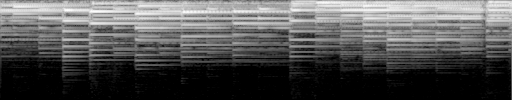

cache/spotify_sleep_dataset/waveform_small/waveform/34938.wav


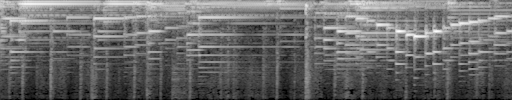

cache/spotify_sleep_dataset/waveform_small/waveform/42511.wav


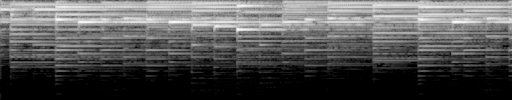

cache/spotify_sleep_dataset/waveform_small/waveform/42963.wav


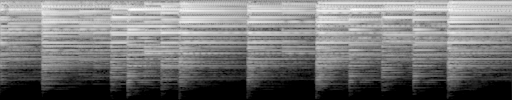

cache/spotify_sleep_dataset/waveform_small/waveform/43884.wav


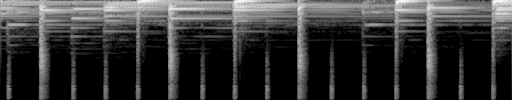

In [64]:
from datasets import Dataset, load_dataset, load_from_disk
from torchvision.transforms import Compose, Normalize, ToTensor
import os
import random
import torch
import torch.nn.functional as F

# arrow_dir = "cache/spotify_sleep_dataset/mel_spec_512_100_waveform_small/train"
arrow_dir = "cache/spotify_sleep_dataset/mel_spec_512_100_waveform_small/train"
# arrow_dir = "cache/spotify_sleep_dataset/mel_spec_2048_128_sr22k_c1/train"
# arrow_dir = "cache/spotify_sleep_dataset/mel_spec_512_80_sr22k_c1/train"
arrow_files = [os.path.join(arrow_dir, file) for file in os.listdir(arrow_dir) if file.endswith(".arrow")]

num_mels = 5
mels = []
dataset = load_from_disk(arrow_dir)
count = 0
for i,d in enumerate(dataset):
    audio = d['audio_file']
    slice = d['slice']
    
    if count < num_mels and slice == 0:
        print(audio)
        mel = d['image']
        display(mel)
        mels.append(mel)
        
        count += 1

    

augmentations = Compose([
    ToTensor(),
    Normalize([0.5], [0.5]),
])

def transforms(examples):
    images = [augmentations(image) for image in examples["image"]]
    return {"input": images}

mels = [augmentations(image) for image in mels]
mel_preset = mels[0]


In [93]:
from PIL import Image
import torch
from torchvision.transforms import Compose, ToTensor, Normalize

augmentations = Compose([
    ToTensor(),
    Normalize([0.5], [0.5]),
])

# Load the image using PIL
image_path = 'test/mel_specs/images/sch_ddpm_nisteps_1000/image_2.png'
image = Image.open(image_path)  # Convert to RGB if the image isn't already in RGB

# Apply augmentations
transformed_image = augmentations(image)

# Wrap in a function if needed
def transforms(examples):
    images = [augmentations(image) for image in examples["image"]]
    return {"input": images}

# Example usage with a list of images
examples = {"image": [image]}
transformed_examples = transforms(examples)

# The transformed tensor
mel_preset = transformed_image
print("Transformed Tensor Shape:", mel_preset.shape)

Transformed Tensor Shape: torch.Size([1, 128, 2048])


In [94]:
def scale_to_range(tnsr, omin, omax, nmin, nmax):
    return nmin + ((tnsr - omin) / (omax - omin)) * (nmax - nmin)

min_old, max_old = -1, 1
min_new, max_new = -11.5129, 0.8571

mel_preset = scale_to_range(mel_preset, min_old, max_old, min_new, max_new)
mel_preset

tensor([[[ -5.2066,  -4.8185,  -4.8671,  ...,  -4.7700,  -5.4492,  -6.7104],
         [ -4.1394,  -3.7028,  -3.9939,  ...,  -4.6730,  -5.0126,  -6.1768],
         [ -3.6058,  -3.3147,  -3.8484,  ...,  -3.9454,  -3.8969,  -5.0126],
         ...,
         [ -9.7180,  -9.5240,  -9.4755,  ..., -11.4159, -11.4159, -10.1546],
         [-10.2516,  -9.9606, -10.1546,  ..., -11.4644, -11.4159, -10.1546],
         [-11.5129, -11.5129, -11.4644,  ..., -11.4644, -11.4159, -10.4457]]])

In [95]:
mel_preset_trunc = mel_preset[:, :80, :512]
print(mel_preset_trunc.shape)

mel_preset_warped = F.interpolate(mel_preset.unsqueeze(1), size=(80, 512), mode='bilinear', align_corners=False).squeeze(1)
print(mel_preset_warped.shape)

torch.Size([1, 80, 512])
torch.Size([1, 80, 512])


/home/th716/.conda/envs/bigvgan_extra/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Loading weights from nvidia/bigvgan_v2_22khz_80band_256x


/home/th716/BigVGAN/bigvgan.py:482: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(model_file, map_location=map_location)


Removing weight norm...


======================0======================
mel.shape=torch.Size([1, 80, 2583])
mel.dtype=torch.float32
mel=tensor([[[ -3.0616,  -3.2884,  -3.3215,  ...,  -3.4947,  -3.5722,  -3.3727],
         [ -2.7521,  -3.0334,  -2.4633,  ...,  -3.6972,  -3.2944,  -3.3643],
         [ -1.5844,  -2.0623,  -2.0657,  ...,  -3.2718,  -3.5088,  -3.3002],
         ...,
         [ -9.3518,  -9.5353, -10.0629,  ...,  -9.0743,  -9.7277,  -8.3199],
         [ -8.3323,  -9.7341, -10.8375,  ..., -10.0492, -10.5020,  -8.2243],
         [ -8.1405,  -9.2382,  -9.9183,  ...,  -9.6734, -10.3031,  -7.9024]]],
       device='cuda:0')


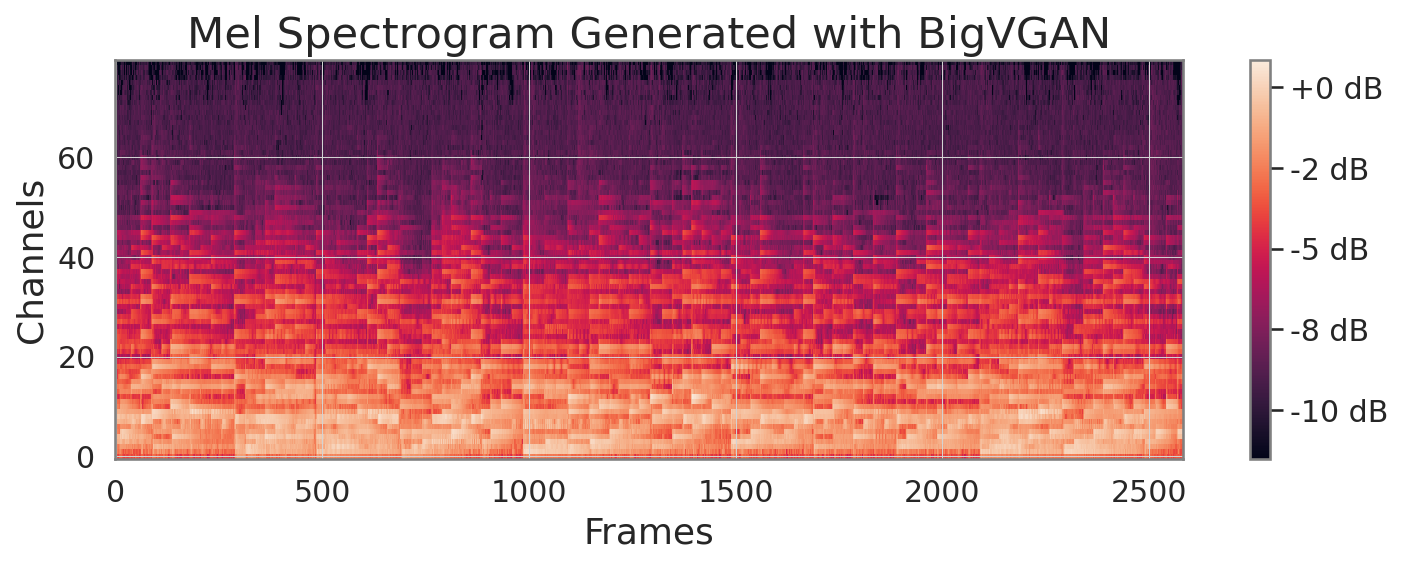

Original Audio:


Generated Audio:




======================1======================
mel.shape=torch.Size([1, 80, 512])
mel.dtype=torch.float32
mel=tensor([[[ -4.5445,  -4.6075,  -3.6034,  ...,  -5.5510,  -5.7815,  -5.0296],
         [ -3.6082,  -3.2250,  -2.5774,  ...,  -3.1619,  -3.4481,  -4.0133],
         [ -1.7503,  -1.7018,  -2.2718,  ...,  -2.6235,  -2.8539,  -3.2541],
         ...,
         [ -9.9000,  -9.5240,  -9.9485,  ...,  -8.8085,  -9.0510, -11.3552],
         [ -9.5555, -10.3074, -10.2225,  ..., -10.9575, -10.0697, -11.4183],
         [-11.0593, -11.4644, -11.0787,  ..., -11.4498, -11.4717, -11.4401]]])


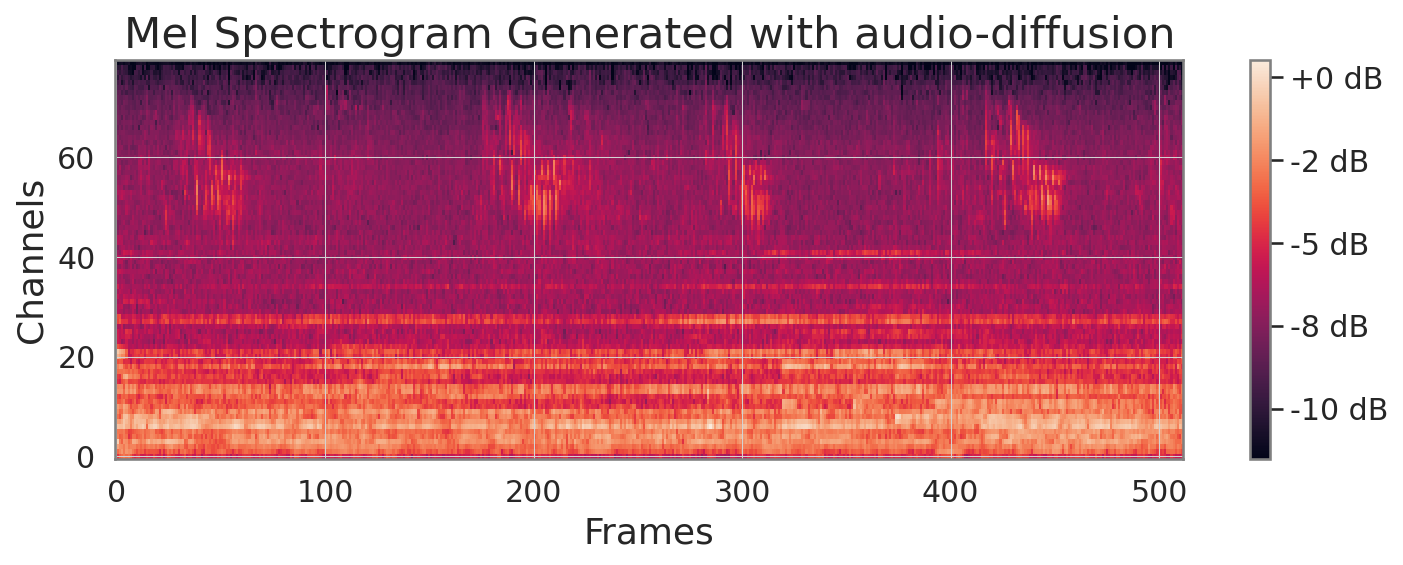

Original Audio:


Generated Audio:




======================2======================
mel.shape=torch.Size([1, 80, 512])
mel.dtype=torch.float32
mel=tensor([[[-5.2066, -4.8185, -4.8671,  ..., -4.7700, -4.9156, -5.7402],
         [-4.1394, -3.7028, -3.9939,  ..., -4.4790, -4.6730, -4.8185],
         [-3.6058, -3.3147, -3.8484,  ..., -3.3147, -3.2662, -2.9752],
         ...,
         [-7.1470, -6.6134, -6.7589,  ..., -6.9530, -6.3224, -6.4194],
         [-6.9045, -6.4194, -6.5164,  ..., -7.7776, -7.0985, -7.1955],
         [-7.1955, -6.8074, -7.0500,  ..., -7.1470, -6.5164, -7.0985]]])


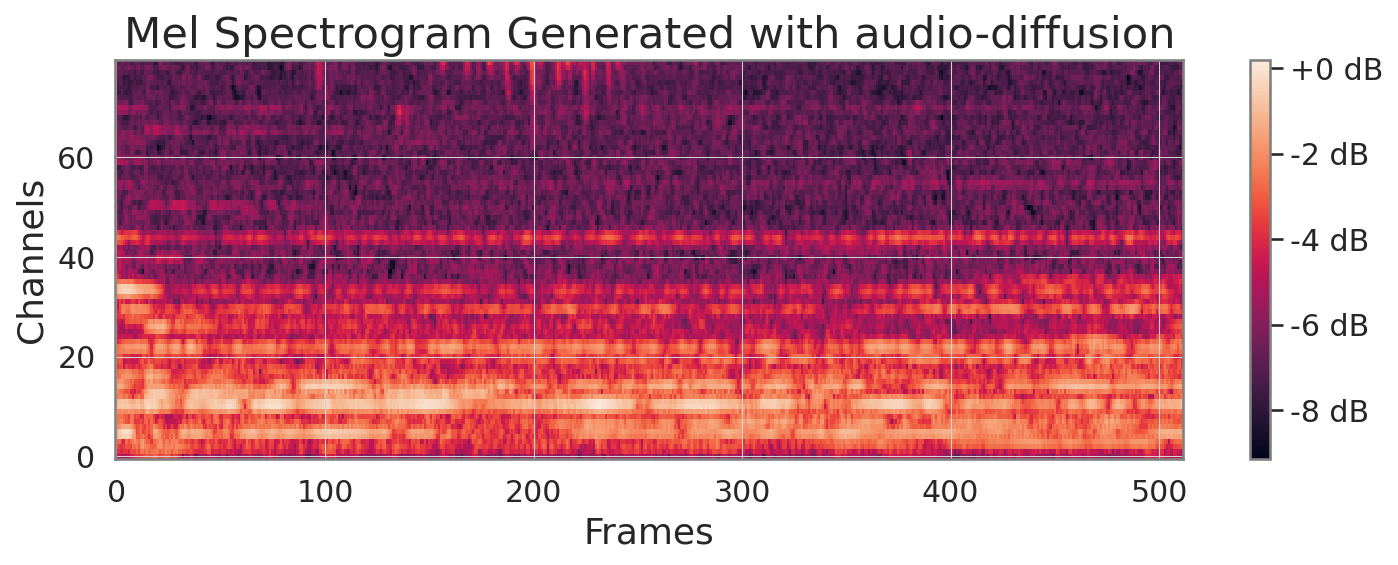

Original Audio:


Generated Audio:


In [99]:
%matplotlib inline

import torch
import bigvgan
import librosa
import matplotlib.pyplot as plt
from meldataset import get_mel_spectrogram
from IPython.display import Audio

# Set the device
device = 'cuda'
preset_mel = True

# Instantiate the model
# model = bigvgan.BigVGAN.from_pretrained('nvidia/bigvgan_v2_24khz_100band_256x', use_cuda_kernel=False)
model = bigvgan.BigVGAN.from_pretrained('nvidia/bigvgan_v2_22khz_80band_256x', use_cuda_kernel=False)

# Remove weight norm in the model and set it to eval mode
model.remove_weight_norm()
model = model.eval().to(device)

# Load wav file and compute mel spectrogram
wav_path = 'cache/spotify_sleep_dataset/val/45968.wav'
wav, sr = librosa.load(wav_path, sr=model.h.sampling_rate, mono=True)  # wav is np.ndarray with shape [T_time] and values in [-1, 1]
wav = torch.FloatTensor(wav).unsqueeze(0)  # wav is FloatTensor with shape [B(1), T_time]

mel_gen = get_mel_spectrogram(wav, model.h).to(device)
mel_gen_numpy = mel_gen.squeeze(0).cpu().numpy()

mel_preset = mel_preset.to(device)
mel_preset_numpy = mel_preset.squeeze(0).cpu().numpy()

for ind, mel in enumerate([
    mel_gen, # from bigvgan repo
    # mel_preset, # from dataset
    mel_preset_warped, # scaled
    mel_preset_trunc # truncated top (highest frequencies) of vector
]):
    print(f'\n\n======================{ind}======================')
    print(f'{mel.shape=}')
    print(f'{mel.dtype=}')
    print(f'{mel=}')
    
    mel = mel.to(device)
    
    # Generate waveform from mel
    with torch.inference_mode():
        wav_gen = model(mel)  # wav_gen is FloatTensor with shape [B(1), 1, T_time] and values in [-1, 1]
    wav_gen_float = wav_gen.squeeze(0).cpu().numpy()  # wav_gen is now np.ndarray with shape [T_time]

    # Visualize the mel spectrogram
    mel_numpy = mel.squeeze(0).cpu().numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_numpy, aspect='auto', origin='lower', interpolation='none')
    plt.colorbar(format='%+2.0f dB')
    title = 'Mel Spectrogram Generated with BigVGAN' if ind==0 else 'Mel Spectrogram Generated with audio-diffusion'
    plt.title(title)
    plt.xlabel('Frames')
    plt.ylabel('Channels')
    plt.tight_layout()
    plt.savefig('test')
    plt.show()
    plt.close()

    # Display the original audio
    print("Original Audio:")
    display(Audio(wav.squeeze(0).cpu().numpy(), rate=sr))

    # Display the generated audio
    print("Generated Audio:")
    display(Audio(wav_gen_float, rate=sr))

### Analyze Difference between me-spectrogram generation methods

In [110]:
import os
import numpy as np
import torch
import librosa
from datasets import load_from_disk
from torchvision.transforms import Compose, Normalize, ToTensor
from bigvgan import BigVGAN
from tqdm import tqdm

# Constants
NUM_IMAGES = 30
ARROW_DIR = "cache/spotify_sleep_dataset/mel_spec_512_80_sr22k_c1/train"
WAV_DIR = "cache/spotify_sleep_dataset/train"
DEVICE = 'cuda'
MIN_OLD, MAX_OLD = -1, 1
MIN_NEW, MAX_NEW = -11.5129, 0.8571
wav_files = []

# Lists to store results
method1_images = []
method2_images = []
method3_images = []

# Method 1: Load mel spectrogram images from dataset
def method1():
    dataset = load_from_disk(ARROW_DIR)
    augmentations = Compose([
        ToTensor(),
        Normalize([0.5], [0.5]),
    ])

    count = 0
    for d in dataset:
        if d['slice'] == 0:
            image = augmentations(d['image'])
            method1_images.append(image.numpy())
            count += 1
            wav_files.append(d['audio_file'])
            if count >= NUM_IMAGES:
                break

# Method 2: Scale the images obtained in method 1
def method2():
    for image in method1_images:
        image_scaled = MIN_NEW + ((image - MIN_OLD) / (MAX_OLD - MIN_OLD)) * (MAX_NEW - MIN_NEW)
        method2_images.append(image_scaled)

# Method 3: Generate mel spectrograms from audio files
def method3():
    model = BigVGAN.from_pretrained('nvidia/bigvgan_v2_22khz_80band_256x', use_cuda_kernel=False)
    model.remove_weight_norm()
    model = model.eval().to(DEVICE)

    # wav_files = [os.path.join(WAV_DIR, file) for file in os.listdir(WAV_DIR) if file.endswith(".wav")]

    count = 0
    for wav_path in tqdm(wav_files):
        wav, sr = librosa.load(wav_path, sr=model.h.sampling_rate, mono=True)
        wav_tensor = torch.FloatTensor(wav).unsqueeze(0).to(DEVICE)
        mel_gen = get_mel_spectrogram(wav_tensor, model.h).to(DEVICE)
        mel_gen_truncated = mel_gen[:, :, :512].squeeze(0).cpu().numpy()
        method3_images.append(mel_gen_truncated)
        count += 1
        if count >= NUM_IMAGES:
            break

# Execute all methods
method1()
method2()
method3()

# Convert lists to NumPy arrays (optional, for consistency)
method1_images = np.array(method1_images)
method2_images = np.array(method2_images)
method3_images = np.array(method3_images)

print(f"Method 1: {len(method1_images)} images prepared.")
print(f"Method 2: {len(method2_images)} images prepared.")
print(f"Method 3: {len(method3_images)} images prepared.")


Loading weights from nvidia/bigvgan_v2_22khz_80band_256x
Removing weight norm...


 67%|██████▋   | 20/30 [00:00<00:00, 38.01it/s]

[WARNING] Min value of input waveform signal is -1.011905312538147
[WARNING] Max value of input waveform signal is 1.0138205289840698


 97%|█████████▋| 29/30 [00:00<00:00, 35.69it/s]

Method 1: 30 images prepared.
Method 2: 30 images prepared.
Method 3: 30 images prepared.


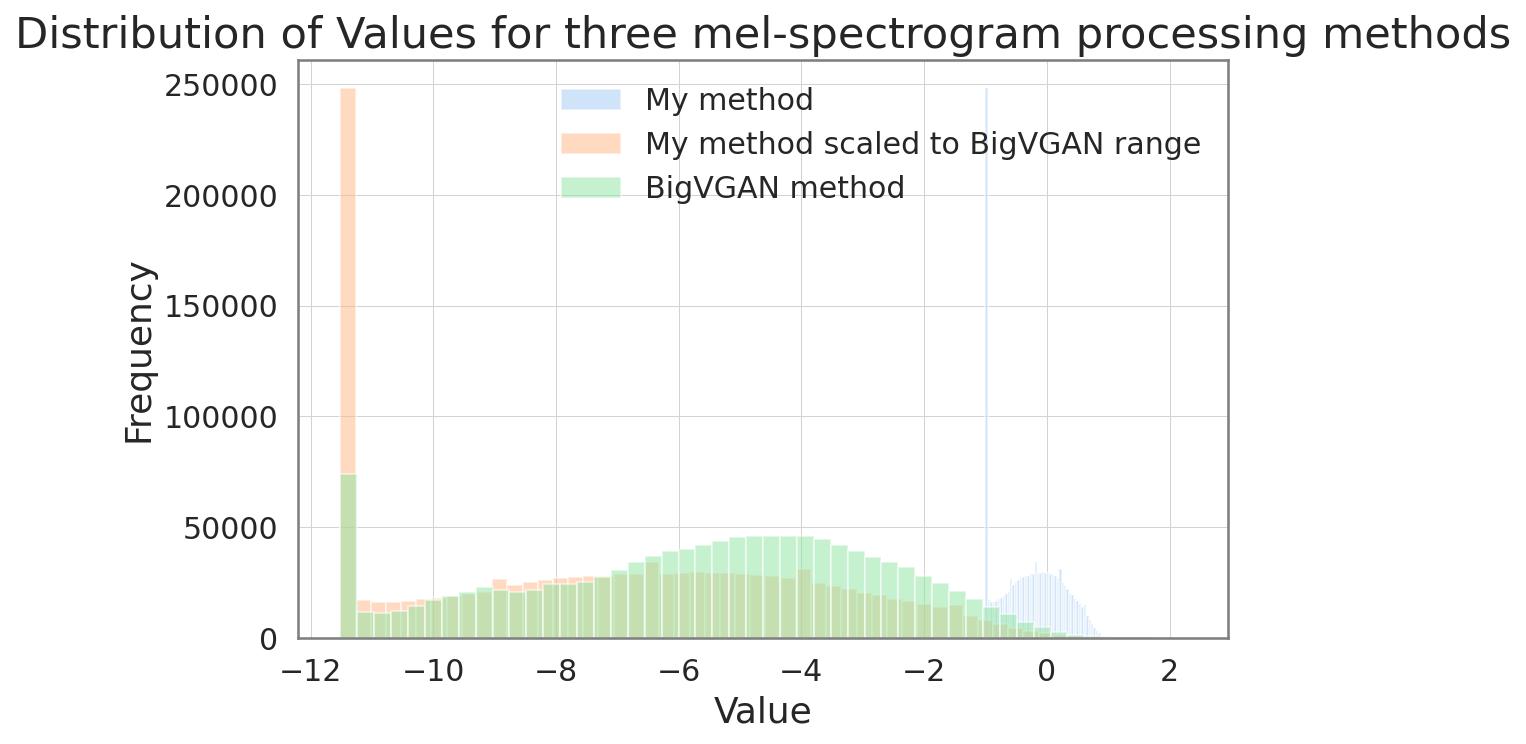

Metrics between Method 1 and Method 2:
  KL Divergence: inf
  JS Divergence: inf
Metrics between Method 1 and Method 3:
  KL Divergence: inf
  JS Divergence: inf
Metrics between Method 2 and Method 3:
  KL Divergence: inf
  JS Divergence: inf


In [112]:
import numpy as np
import matplotlib.pyplot as plt


# Assuming method1_images, method2_images, and method3_images are lists of numpy arrays
def aggregate_and_flatten(image_list):
    # Flatten and combine all images into a single array
    return np.concatenate([image.flatten() for image in image_list])

# Aggregate values for each method
method1_values = aggregate_and_flatten(method1_images)
method2_values = aggregate_and_flatten(method2_images)
method3_values = aggregate_and_flatten(method3_images)

# Plot the distributions
plt.hist(method1_values, bins=50, alpha=0.5, label='My method')
plt.hist(method2_values, bins=50, alpha=0.5, label='My method scaled to BigVGAN range')
plt.hist(method3_values, bins=50, alpha=0.5, label='BigVGAN method')
plt.legend()
plt.title('Distribution of Values for three mel-spectrogram processing methods')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Normalize the distributions to represent probabilities
method1_prob = method1_values / method1_values.sum()
method2_prob = method2_values / method2_values.sum()
method3_prob = method3_values / method3_values.sum()

# Calculate pairwise metrics
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

def calculate_metrics(prob1, prob2, label1, label2):
    # KL Divergence
    kl_div = entropy(prob1, prob2)
    # JS Divergence
    js_div = jensenshannon(prob1, prob2) ** 2
    print(f"Metrics between {label1} and {label2}:")
    print(f"  KL Divergence: {kl_div}")
    print(f"  JS Divergence: {js_div}")

# Calculate metrics for all pairs
calculate_metrics(method1_prob, method2_prob, "Method 1", "Method 2")
calculate_metrics(method1_prob, method3_prob, "Method 1", "Method 3")
calculate_metrics(method2_prob, method3_prob, "Method 2", "Method 3")


In [15]:
mel_gen[:, :, :512].shape

torch.Size([1, 80, 512])

In [15]:
print(torch.min(mel_gen))
print(torch.max(mel_gen))

tensor(-11.5129, device='cuda:0')
tensor(0.8351, device='cuda:0')


In [53]:
model.h

{'resblock': '1',
 'num_gpus': 0,
 'batch_size': 32,
 'learning_rate': 0.0001,
 'adam_b1': 0.8,
 'adam_b2': 0.99,
 'lr_decay': 0.9999996,
 'seed': 1234,
 'upsample_rates': [4, 4, 2, 2, 2, 2],
 'upsample_kernel_sizes': [8, 8, 4, 4, 4, 4],
 'upsample_initial_channel': 1536,
 'resblock_kernel_sizes': [3, 7, 11],
 'resblock_dilation_sizes': [[1, 3, 5], [1, 3, 5], [1, 3, 5]],
 'use_tanh_at_final': False,
 'use_bias_at_final': False,
 'activation': 'snakebeta',
 'snake_logscale': True,
 'use_cqtd_instead_of_mrd': True,
 'cqtd_filters': 128,
 'cqtd_max_filters': 1024,
 'cqtd_filters_scale': 1,
 'cqtd_dilations': [1, 2, 4],
 'cqtd_hop_lengths': [512, 256, 256],
 'cqtd_n_octaves': [9, 9, 9],
 'cqtd_bins_per_octaves': [24, 36, 48],
 'mpd_reshapes': [2, 3, 5, 7, 11],
 'use_spectral_norm': False,
 'discriminator_channel_mult': 1,
 'use_multiscale_melloss': True,
 'lambda_melloss': 15,
 'clip_grad_norm': 500,
 'segment_size': 65536,
 'num_mels': 100,
 'num_freq': 1025,
 'n_fft': 1024,
 'hop_size': 

In [52]:
print(torch.min(mel_gen))
print(torch.max(mel_gen))

tensor(-11.5129, device='cuda:0')
tensor(-0.6919, device='cuda:0')


In [39]:
print(torch.min(mel_gen))
print(torch.max(mel_gen))

tensor(-11.5129, device='cuda:0')
tensor(0.8570, device='cuda:0')


In [28]:
print(torch.min(mel_gen))
print(torch.max(mel_gen))

tensor(-11.5129, device='cuda:0')
tensor(0.8571, device='cuda:0')


In [32]:
mel_numpy.shape

(100, 512)